In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score

## Load the data

In [2]:
df = pd.read_csv("data/interim/final_paths_ordered.csv")
feature_cols = [f"Level {i}" for i in range(1, 8)]
target_col   = "Relative Strength"

X = df[feature_cols]
y = df[target_col]

## Pre-processing: one-hot encode the categorical level strings

In [3]:
encoder = OneHotEncoder(handle_unknown="ignore")            # keeps tree happy with unseen cats
preprocess = ColumnTransformer(
        transformers=[("cat", encoder, feature_cols)],
        remainder="drop"
)

## Decision-tree

In [4]:
MAX_DEPTH = 4 # start shallow and raise if under-fitting

In [5]:
tree = DecisionTreeRegressor(
        criterion="squared_error",
        max_depth=MAX_DEPTH,
        min_samples_leaf=5,   # de-noise tiny sub-clusters
        random_state=42
)

model = Pipeline(steps=[
        ("prep", preprocess),
        ("reg",  tree)
])

 ## Train / evaluate

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
)
model.fit(X_train, y_train)

cv_rmse = (-cross_val_score(
        model, X_train, y_train,
        scoring="neg_root_mean_squared_error",
        cv=5
)).mean()
print(f"5-fold CV RMSE: {cv_rmse:.3f}")

print(f"Test R²: {model.score(X_test, y_test):.3f}")

5-fold CV RMSE: 0.151
Test R²: 0.537


## Extract human-readable rules

In [7]:
feature_names = model.named_steps["prep"].get_feature_names_out()
rules_text = export_text(
        model.named_steps["reg"],
        feature_names=feature_names,
        max_depth=MAX_DEPTH,
)
print(rules_text)

|--- cat__Level 2___G___ <= 0.50
|   |--- cat__Level 3__G_G__ <= 0.50
|   |   |--- cat__Level 3___G_G_ <= 0.50
|   |   |   |--- cat__Level 3____GG_ <= 0.50
|   |   |   |   |--- value: [0.19]
|   |   |   |--- cat__Level 3____GG_ >  0.50
|   |   |   |   |--- value: [0.56]
|   |   |--- cat__Level 3___G_G_ >  0.50
|   |   |   |--- cat__Level 4___G_GG <= 0.50
|   |   |   |   |--- value: [0.76]
|   |   |   |--- cat__Level 4___G_GG >  0.50
|   |   |   |   |--- value: [0.42]
|   |--- cat__Level 3__G_G__ >  0.50
|   |   |--- cat__Level 4__G_GT_ <= 0.50
|   |   |   |--- cat__Level 4__GCG__ <= 0.50
|   |   |   |   |--- value: [0.78]
|   |   |   |--- cat__Level 4__GCG__ >  0.50
|   |   |   |   |--- value: [0.58]
|   |   |--- cat__Level 4__G_GT_ >  0.50
|   |   |   |--- value: [0.48]
|--- cat__Level 2___G___ >  0.50
|   |--- cat__Level 3__GG___ <= 0.50
|   |   |--- cat__Level 3___GG__ <= 0.50
|   |   |   |--- cat__Level 3_G_G___ <= 0.50
|   |   |   |   |--- value: [0.26]
|   |   |   |--- cat__Level

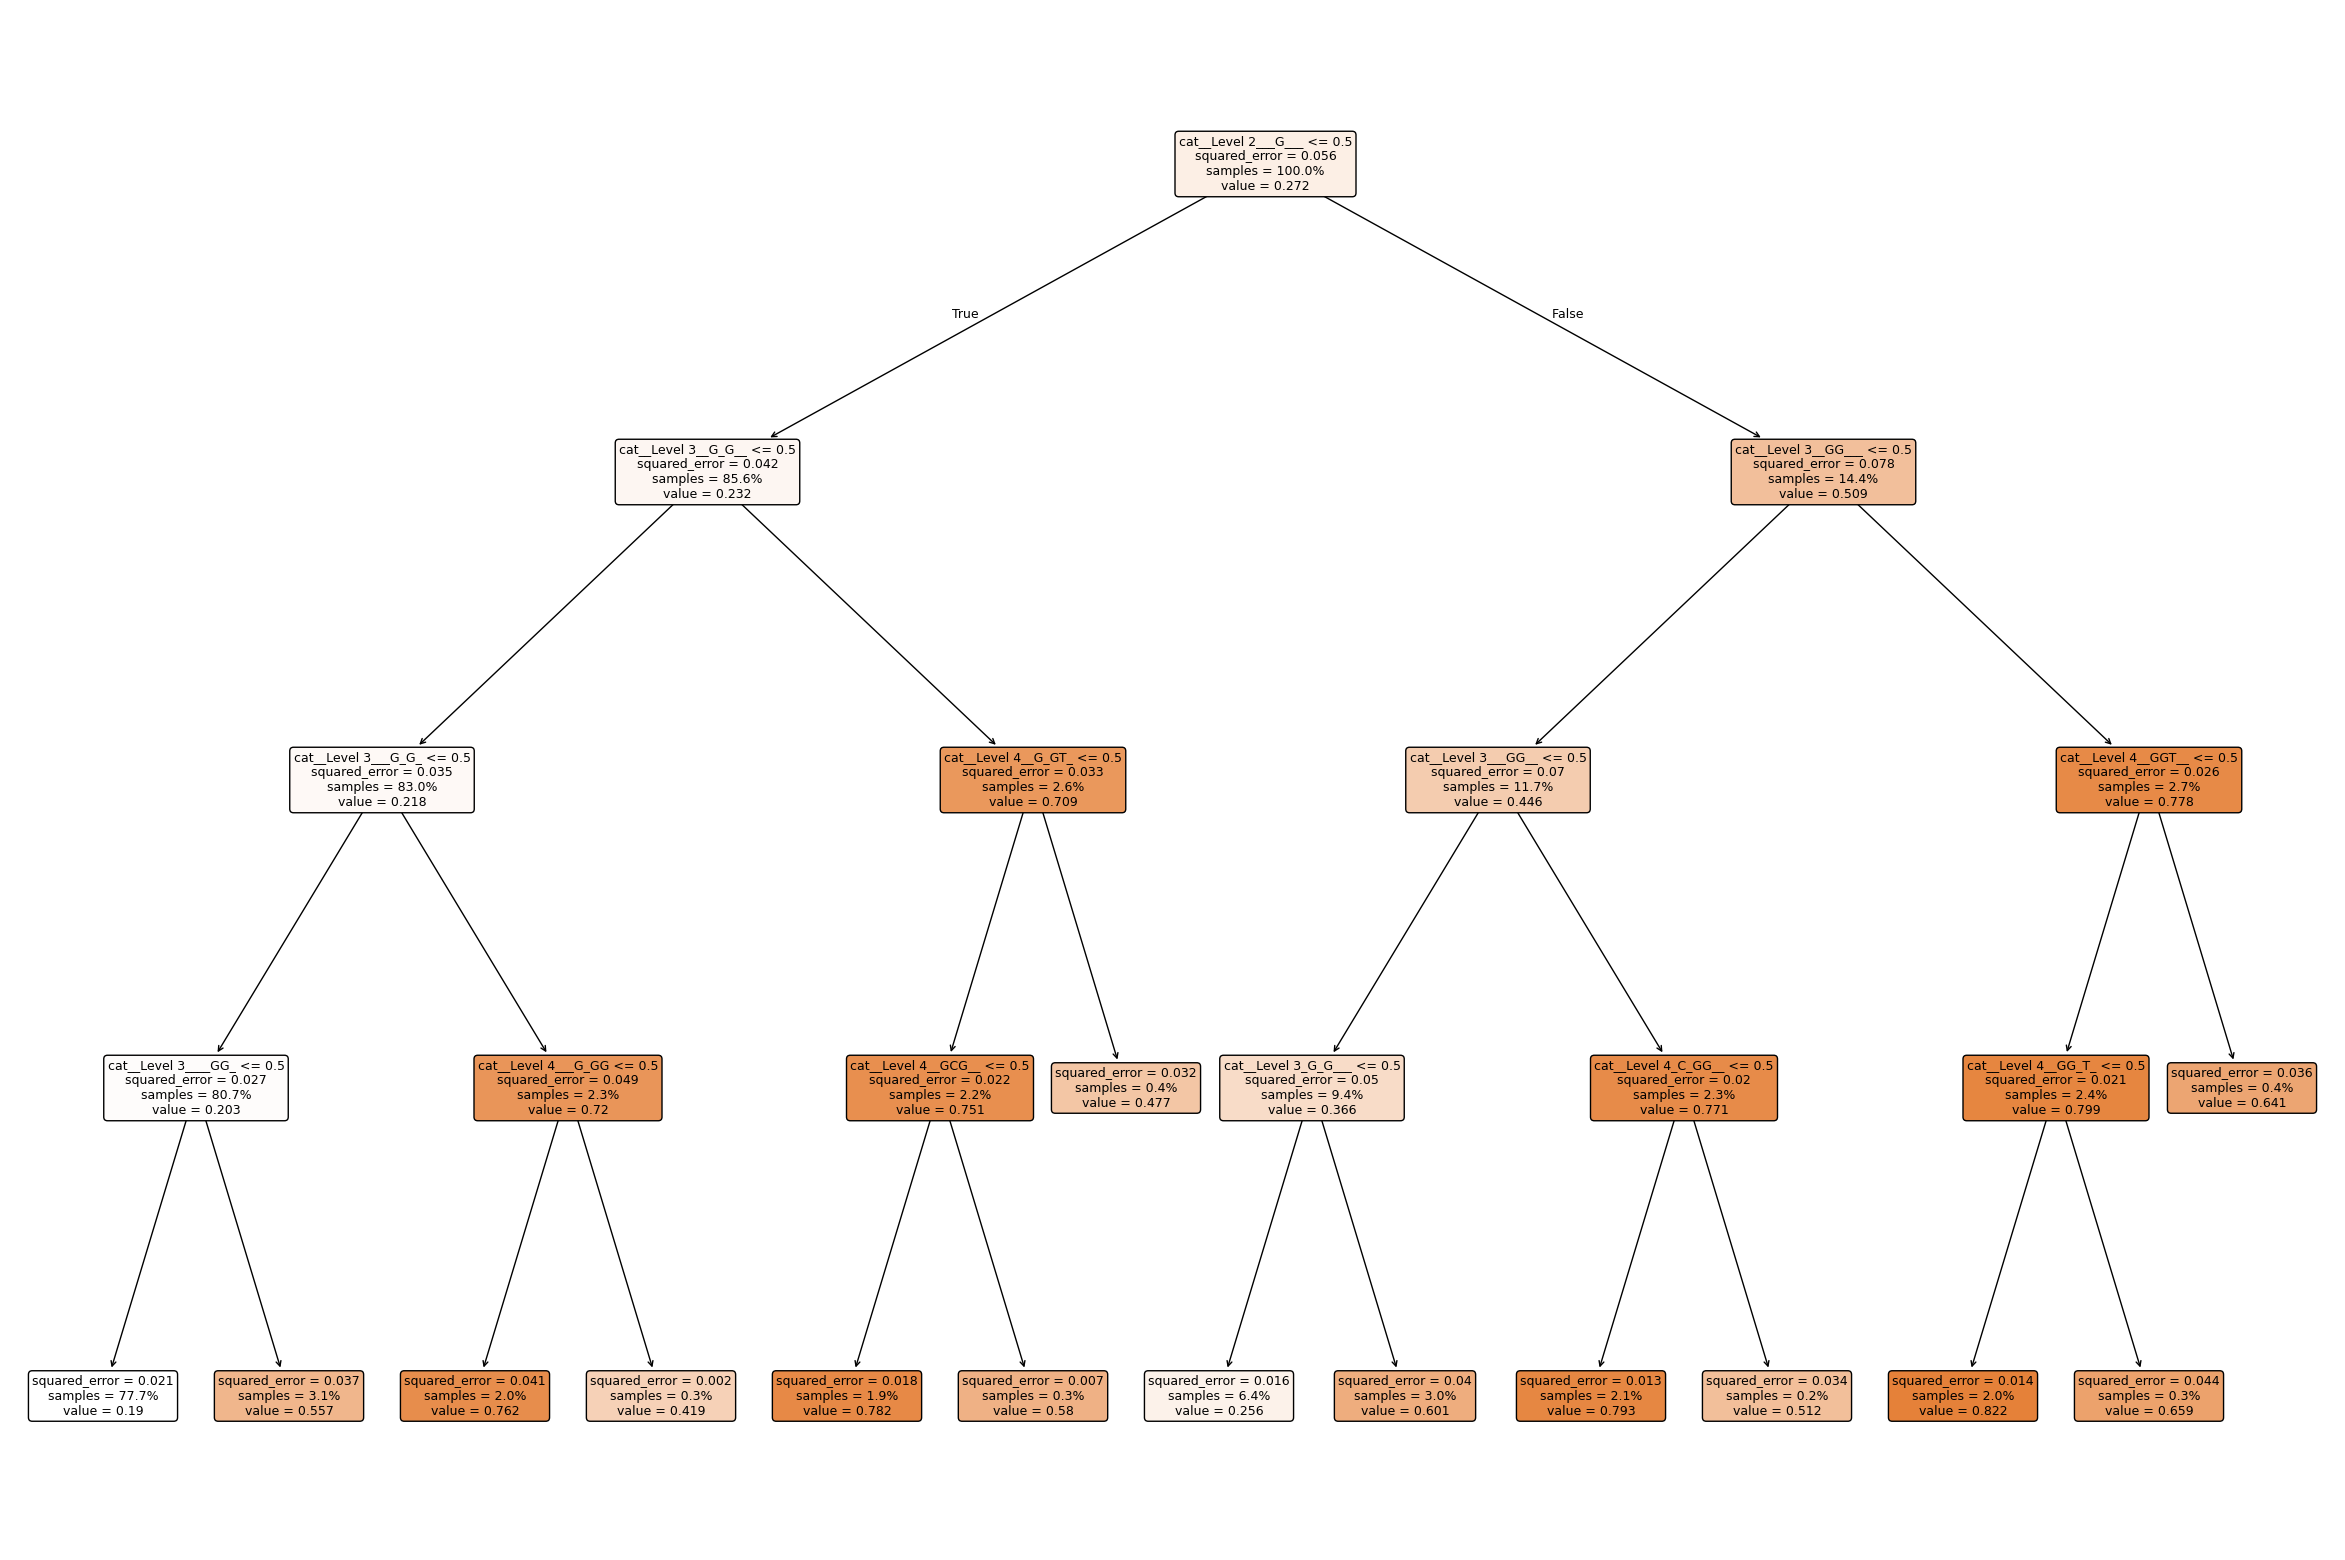

In [8]:
# (Optional) quick visual:
plt.figure(figsize=(30,20))
plot_tree(model.named_steps["reg"],
          feature_names=feature_names,
          filled=True,
          rounded=True,
          proportion=True,
          fontsize=9,
          )
plt.savefig("decision-tree.eps", dpi=400, bbox_inches="tight", format="eps", transparent=True)
plt.show()